In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pyplot
import os,glob
import cv2 as cv

In [2]:
picture_path = "/media/tht/OS/2018机器学习/机器学习课程实验材料/AR/AR/"
Image_list = []
Image_arg = []
for name in glob.glob(picture_path+"*.bmp"):
    Image_arg.append(int(name[len(picture_path):len(picture_path)+3])-1)
    Image = cv.imread(name,cv.IMREAD_GRAYSCALE) # 转换为灰度图
#     print(Image.dtype)
    image = Image.copy().reshape(1,2000) # 将图像压缩成一个1*2000的张量
#     print(image.dtype)
    Image_list.append(image)
    
len(Image_list)

1680

In [3]:
Image_arg

[25,
 51,
 77,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 1,
 2,
 4,
 5,
 7,
 8,
 9,
 11,
 12,
 14,
 15,
 17,
 18,
 19,
 21,
 22,
 24,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,


In [4]:
Image_mat = np.vstack((Image_list)) # 所有图像连接成为一个矩阵
Image_mat[0]

array([254, 254, 254, ..., 254, 254, 254], dtype=uint8)

# 计算与每个样本最近的k近邻
## k为近邻超参数需要自调节
## d为维度超参数需要自调节

In [5]:
def get_distance(train,test):
    return np.sum((train - test)**2,axis = 1)

$$
C_{jk} = (X - n_k)*(X - n_k)
$$

$$
W_j = {\sum_kC_{jk}^{-1} \over \sum_{lm}C_{lm}^{-1}}
$$

In [6]:
from scipy.linalg import solve,eigh,inv
from scipy.sparse import eye, csr_matrix

In [7]:
k = 14
N = Image_mat.shape[0]
M = Image_mat.shape[1]
neighbour_list = []
index_list = []

for i in range(0,N):
    # 求K近邻(此处可以使用K-D树，但因为不知道给不给调用模型外部库，所以用了最暴力的解法)
    now = Image_mat[i]
    distance = get_distance(now,Image_mat)
    index = np.argsort(distance)
    neighbour_index = index[1:k+1] # 因为最小的那个点必为自己故略去
    neighbour = Image_mat[neighbour_index,:]
    n_samples = neighbour.shape[0]
    neighbour_list.append(neighbour)
    index_list.append(neighbour_index)
    
neighbour_mat = np.dstack((neighbour_list)).swapaxes(0,2).swapaxes(1,2)
print(neighbour_mat.shape)
index_mat = np.vstack((index_list))
print(index_mat.shape)

(1680, 14, 2000)
(1680, 14)


In [8]:
# 用计算权重向量向量
def barycenter_weights(X, Z, reg=1e-3):
    n_samples, n_neighbors = X.shape[0], Z.shape[1]
    B = np.empty((n_samples, n_neighbors), dtype=X.dtype)
    v = np.ones(n_neighbors, dtype=X.dtype)
     # Z (1680, 14, 2000) 表示1680张图片对于每张图片我用了14个与其临近的图片来表示而每个图片摊平之后是2000（50*40）
    temp = Z.swapaxes(1,2)
    print(temp.shape)
    # temp (1680, 2000, 14)交换了一下维度为了之后运算方便
    for i in range(len(temp)):
        A = Z[i,:,:]
        C = A.T - X[i]
        G = C.dot(C.T)
        trace = np.trace(G) #求迹（对角线上的元素和）
        if trace > 0:
            R = reg * trace
        else:
            R = reg
        G.flat[::Z.shape[1] + 1] += R
        w = solve(G, v, sym_pos=True)
        B[i, :] = w / np.sum(w) #归一化
    return B

In [9]:
# 求局部协方差矩阵，求出对应的权重系数向量
data = barycenter_weights(Image_mat.astype("float64"),neighbour_mat.astype("float64"))
W = csr_matrix((data.ravel(),index_mat.ravel(), np.arange(0, N * k + 1, k)),shape = (N,N))
W

(1680, 2000, 14)


<1680x1680 sparse matrix of type '<class 'numpy.float64'>'
	with 23520 stored elements in Compressed Sparse Row format>

# 构造矩阵M并求其特征值和特征向量
$$
M = (I－W)^T(I-W)
$$


In [10]:
M = eye(*W.shape, format=W.format) - W
M = (M.T * M).tocsr()
M = M.toarray()

# 对特征值进行排序取前ｄ个

In [11]:
def percentage2n(eig_val,percentage):
    sortArray = np.sort(eig_val)
    sortArray = sortArray[-1::-1]
    Array_sum = sum(sortArray)
    temp = 0
    num =0
    for i in sortArray:
        temp+=i
        num+=1
        if temp>=Array_sum*percentage:
            return num

In [12]:
eig_val,eig_vector = np.linalg.eig(M)
print(eig_val.shape)
print(eig_vector.shape)
sorted_eig_val = np.argsort(np.abs(eig_val))
sorted_eig_val.shape
# d = percentage2n(eig_val,0.8)
d = 20
print(d)
D_eig_vector = eig_vector[:,sorted_eig_val[0:d]]
D_eig_vector.shape

(1680,)
(1680, 1680)
20


(1680, 20)

In [13]:
D_eig_vector

array([[-0.0243975 , -0.02084208, -0.1049658 , ..., -0.00252158,
        -0.04670258, -0.0436318 ],
       [-0.0243975 , -0.01631709,  0.01120259, ...,  0.0202674 ,
        -0.00852608, -0.00569929],
       [-0.0243975 ,  0.00517427,  0.02051796, ..., -0.01572566,
        -0.00508534, -0.02691462],
       ...,
       [-0.0243975 ,  0.03533144,  0.0016427 , ...,  0.01713583,
         0.00456264, -0.03153534],
       [-0.0243975 ,  0.02938103,  0.0067617 , ...,  0.01253323,
        -0.00601482, -0.01673786],
       [-0.0243975 ,  0.02874357,  0.00842028, ...,  0.01942692,
        -0.00267786, -0.01603461]])

In [14]:
from sklearn.manifold import LocallyLinearEmbedding
lle = LocallyLinearEmbedding(n_components=d,n_neighbors=k,eigen_solver='dense')
X_r=lle.fit_transform(Image_mat)

In [15]:
X_r

array([[-0.01473051, -0.06392477,  0.02055449, ...,  0.01511119,
        -0.01389212,  0.02242259],
       [-0.01756709,  0.01933774, -0.00164929, ...,  0.00018833,
         0.00026093, -0.01396333],
       [ 0.007646  ,  0.01259958,  0.01276258, ..., -0.09213241,
         0.01239789, -0.03610415],
       ...,
       [ 0.03641948, -0.00029328, -0.00887377, ...,  0.03517855,
         0.00039626,  0.01967791],
       [ 0.03375347,  0.00043225, -0.0073409 , ...,  0.04754302,
        -0.00694938,  0.03085795],
       [ 0.03308454,  0.00233728, -0.01031782, ...,  0.03192169,
        -0.00417816,  0.01636521]])

In [16]:
X_r.shape

(1680, 20)

# 计算sklearn的LLE和自编写的LLE的总误差

In [17]:
np.sum((X_r - D_eig_vector)**2)

38.84828450851926

# 计算重建误差

In [18]:
Image_list_new = []

for i in range(neighbour_mat.shape[0]):
    Image_list_new.append(data[i].dot(neighbour_mat[i]))

Y = np.vstack((Image_list_new))
Y.shape

(1680, 2000)

## 原本的图像

dtype('uint8')

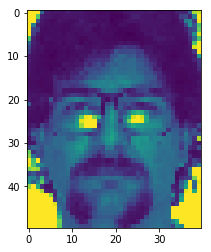

In [19]:
pyplot.imshow(Image_mat[0].reshape(50,40))
Image_mat[0].dtype

## 重建后的图像

dtype('float64')

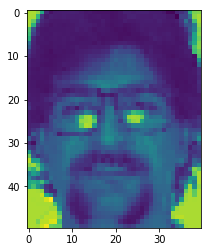

In [20]:
pyplot.imshow(Y[0].reshape(50,40))
Y[0].dtype

In [21]:
def get_deviation(pre,after):
    return np.sum((after - pre)**2) / np.sum(pre**2)

In [22]:
print(get_deviation(Image_mat[0].astype('float64'),Y[0,:].astype('float64')))

0.03351035870067735


# 最近临法判别身份，评估识别准确率

In [23]:
def get_LLE(Image_mat):
    k = 14
    N = Image_mat.shape[0]
    M = Image_mat.shape[1]
    neighbour_list = []
    index_list = []

    for i in range(0,N):
        # 求K近邻(此处可以使用K-D树，但因为不知道给不给调用模型外部库，所以用了最暴力的解法)
        now = Image_mat[i]
        distance = get_distance(now,Image_mat)
        index = np.argsort(distance)
        neighbour_index = index[1:k+1] # 因为最小的那个点必为自己故略去
        neighbour = Image_mat[neighbour_index,:]
        n_samples = neighbour.shape[0]
        neighbour_list.append(neighbour)
        index_list.append(neighbour_index)
    
    neighbour_mat = np.dstack((neighbour_list)).swapaxes(0,2).swapaxes(1,2)
    index_mat = np.vstack((index_list))
    
    # 求局部协方差矩阵，求出对应的权重系数向量
    data = barycenter_weights(Image_mat.astype("float64"),neighbour_mat.astype("float64"))
    W = csr_matrix((data.ravel(),index_mat.ravel(), np.arange(0, N * k + 1, k)),shape = (N,N))
    M = eye(*W.shape, format=W.format) - W
    M = (M.T * M).tocsr()
    M = M.toarray()
    
    eig_val,eig_vector = np.linalg.eig(M)
    sorted_eig_val = np.argsort(np.abs(eig_val))
#     d = percentage2n(eig_val,0.8)
    d = 20
    D_eig_vector = eig_vector[:,sorted_eig_val[0:d]]
    
    return D_eig_vector,data,neighbour_mat

In [24]:
Image_list_new = []
Image_arg_new = []
for name in glob.glob(picture_path+"*-02.bmp"):
    Image_arg_new.append(int(name[len(picture_path):len(picture_path)+3])-1)
    Image = cv.imread(name,cv.IMREAD_GRAYSCALE) # 转换为灰度图
#     print(Image.dtype)
    image = Image.copy().reshape(1,2000) # 将图像压缩成一个1*2000的张量
#     print(image.dtype)
    Image_list_new.append(image)
    
Image_mat_new = np.vstack((Image_list_new)) # 所有图像连接成为一个矩阵  
D_eig_vector_new,data_new,neighbour_mat_new = get_LLE(Image_mat_new)
D_eig_vector_new.shape,data_new.shape,neighbour_mat_new.shape

(120, 2000, 14)


((120, 20), (120, 14), (120, 14, 2000))

In [83]:
Image_arg_new

[77,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 17,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 48,
 49,
 50,
 51,
 52,
 27,
 37,
 47,
 53,
 54,
 55,
 56,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 78,
 57,
 67,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 87,
 97,
 107,
 117,
 105,
 106,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 118,
 119]

## 自己编写的LLE

In [85]:
right_size = 0

for i in range(0,Image_mat_new.shape[0]):
    distance = get_distance(D_eig_vector_new[i],D_eig_vector)
    min_arg = np.argmin(distance)
    if Image_arg[min_arg] == Image_arg_new[i]:
        right_size+=1

print(right_size / Image_mat_new.shape[0])

0.016666666666666666


## sklearn的LLE

In [86]:
from sklearn.manifold import LocallyLinearEmbedding
lle = LocallyLinearEmbedding(n_components=d,n_neighbors=k,eigen_solver='dense')
X_r_new=lle.fit_transform(Image_mat_new)

right_size = 0

for i in range(0,Image_mat_new.shape[0]):
    distance = get_distance(X_r[i],X_r_new)
    min_arg = np.argmin(distance)
    if Image_arg[min_arg] == Image_arg_new[i]:
        right_size+=1

print(right_size / Image_mat_new.shape[0])

0.008333333333333333


**关于这个准确率问题我觉得多半是因为我在处理矩阵的时候信息丢失了导致准确的target出现了问题**

In [6]:
a = np.array([
    [
        [1,2,3],
        [4,5,6],
    ],
    [
        [7,8,9],
        [10,11,12]
    ]
])
a.shape

(2, 2, 3)

In [7]:
a[:,0,:]

array([[1, 2, 3],
       [7, 8, 9]])

In [8]:
a[:,0,:].shape

(2, 3)